<a href="https://www.kaggle.com/code/sneha9920/malaria-dataset-book?scriptVersionId=188273175" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malaria/cell_images/Uninfected/C203ThinF_IMG_20151029_102123_cell_51.png
/kaggle/input/malaria/cell_images/Uninfected/C238NThinF_IMG_20151207_114038_cell_84.png
/kaggle/input/malaria/cell_images/Uninfected/C119P80ThinF_IMG_20151002_124304_cell_112.png
/kaggle/input/malaria/cell_images/Uninfected/C39P4thinF_original_IMG_20150622_111723_cell_33.png
/kaggle/input/malaria/cell_images/Uninfected/C101P62ThinF_IMG_20150918_151149_cell_63.png
/kaggle/input/malaria/cell_images/Uninfected/C180P141NThinF_IMG_20151201_165601_cell_115.png
/kaggle/input/malaria/cell_images/Uninfected/C95P56ThinF_IMG_20150821_171603_cell_75.png
/kaggle/input/malaria/cell_images/Uninfected/C236ThinF_IMG_20151127_102516_cell_177.png
/kaggle/input/malaria/cell_images/Uninfected/C125P86ThinF_IMG_20151004_102053_cell_83.png
/kaggle/input/malaria/cell_images/Uninfected/C49P10thinF_IMG_20150724_102330_cell_160.png
/kaggle/input/malaria/cell_images/Uninfected/C109P70ThinF_IMG_20150930_102716_cell_63.png
/kaggle

Number of images in train set: 22046
Number of images in test set: 5512


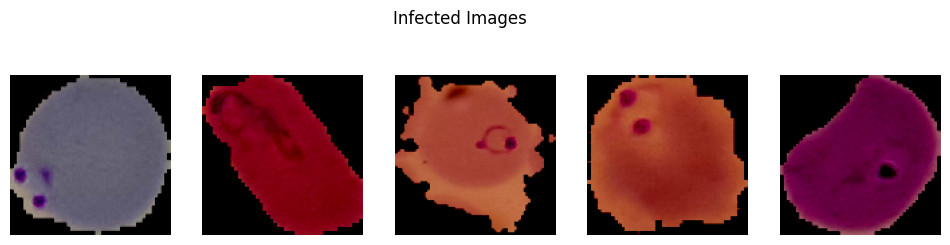

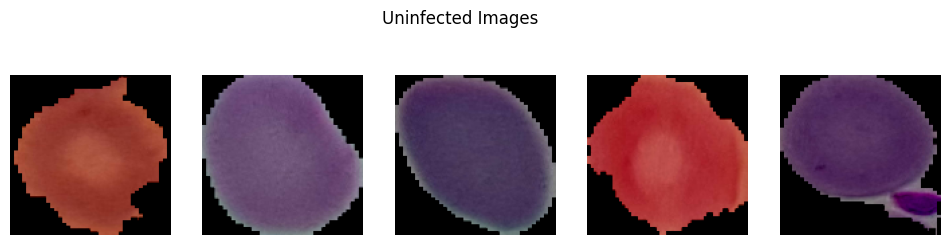

Epoch [1/30], Train Loss: 0.6202, Train Accuracy: 66.26%, Test Accuracy: 67.51%
Epoch [2/30], Train Loss: 0.6046, Train Accuracy: 67.75%, Test Accuracy: 68.03%
Epoch [3/30], Train Loss: 0.5975, Train Accuracy: 68.35%, Test Accuracy: 68.61%
Epoch [4/30], Train Loss: 0.5895, Train Accuracy: 69.23%, Test Accuracy: 67.94%
Epoch [5/30], Train Loss: 0.5862, Train Accuracy: 69.75%, Test Accuracy: 69.07%
Epoch [6/30], Train Loss: 0.5844, Train Accuracy: 69.67%, Test Accuracy: 68.87%
Epoch [7/30], Train Loss: 0.5798, Train Accuracy: 70.12%, Test Accuracy: 69.19%
Epoch [8/30], Train Loss: 0.5785, Train Accuracy: 70.14%, Test Accuracy: 69.52%
Epoch [9/30], Train Loss: 0.5776, Train Accuracy: 70.26%, Test Accuracy: 68.90%
Epoch [10/30], Train Loss: 0.5751, Train Accuracy: 70.51%, Test Accuracy: 69.50%
Epoch [11/30], Train Loss: 0.5748, Train Accuracy: 70.55%, Test Accuracy: 69.18%
Epoch [12/30], Train Loss: 0.5742, Train Accuracy: 70.63%, Test Accuracy: 68.89%
Epoch [13/30], Train Loss: 0.5730, Tr

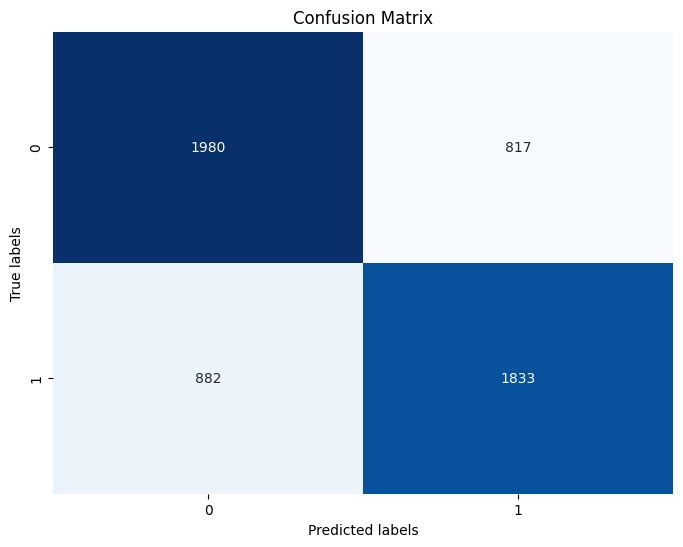

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split


transforms = transforms.Compose([transforms.Resize((120, 120)),transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

image_dir = "/kaggle/input/malaria/cell_images"
full_dataset = datasets.ImageFolder(image_dir)

train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

train_subset.dataset.transform = transforms
test_subset.dataset.transform = transforms

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

classes = ['infected', 'uninfected']

def get_batch(loader, class_index, num_images):
    for batch, labels in loader:
        images = batch[labels == class_index][:num_images]
        return images

infected_images = get_batch(train_loader, class_index=0, num_images=5)
show_images(infected_images, 'Infected Images')

uninfected_images = get_batch(train_loader, class_index=1, num_images=5)
show_images(uninfected_images, 'Uninfected Images')

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

input_size = 120 * 120 * 3
num_classes = 2
num_epochs = 30
best_test_accuracy = 0.0
early_stopping_patience = 6
early_stopping_counter = 0

model = LogisticRegressionModel(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = StepLR(optimizer,step_size=3, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy, test_accuracy))

    scheduler.step()

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping at epoch', epoch+1)
            break

print('Finished Training')

model.eval()
true_labels = []
predicted_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        predicted_probabilities.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

predicted_labels = np.argmax(predicted_probabilities, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

print('Classification Report:')
print(classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()